In [56]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl

import numpy as np

plt.style.use('ggplot')

pd.__version__

u'0.17.0'

In [57]:
SSF_subsidies = pd.read_csv("SSF_subsidies.csv")
countries = pd.read_csv("Country_Data.csv")
catch = pd.read_csv("SAU_Catches.csv")
type_EEZ = pd.read_csv("Subtype_Fleet_EEZ.csv")
all_subsidies = pd.read_csv("Subsidies2009.csv")

In [58]:


SSF_subsidies['SSF_subsidies_percent'] = SSF_subsidies['SSF_USD_1000']/SSF_subsidies['total_subsidies']


#  merge original all subsidies data with to align with subsidy 
#  type and whether the EEZ catch data or the FLeet catch data apply, 
#  see type_EEZ data, this is in preparation to later merge with SAU_catch data 

subsidies_type = pd.merge(
    left=all_subsidies,
    right=type_EEZ,
    how='left'
)


#  now this needs to be merged with country data to have coordinates per country
#  and have each country data point assigned to a subregion (thanks to Andres data)

subsidies_type_countries = pd.merge(
    left=subsidies_type,
    right=countries,
    how='left'
)


#  calculate SSF catch percent by dividing SSF catch / total catch

catch['SSF_catch_percent']=catch['SSF_catch']/catch['total_catch']


#  merge with SSF catch from SAU_catch data

subsidies_type_countries_catch = pd.merge(
    left=subsidies_type_countries,
    right=catch, how='left'
)

#  calculating mean SSF catch per subregion, 
#  needed to use to fill gaps for SSF subsidies that have not been assessed

catch_countries = pd.merge(
    left=catch, 
    right=countries, 
    how='left'
)

In [59]:

catch_by_subregion = catch_countries.groupby(['Subregion']).sum()
catch_by_subregion['SSF_subregion_catch'] = (
    catch_by_subregion['SSF_catch']/catch_by_subregion['total_catch']
)

catch_by_subregion = catch_by_subregion.reset_index()

SSF_subregion_catch = catch_by_subregion.loc[:,['Subregion','SSF_subregion_catch']]



#  merging mean catch with all subsidies data
subsidies_type_countries_catch_meancatch = pd.merge(
    left=subsidies_type_countries_catch,right=SSF_subregion_catch, how='left'
) 

#  preparing SSF subsidies by merging with country data
SSF_subsidies_countries = pd.merge(
    left=SSF_subsidies,right=countries, how='left')

#  from SSF subsidies assessed calculate mean per subregion and per type 
#  to fill gaps of countries that have not been assessed
SSF_by_subregion = SSF_subsidies_countries.groupby(
    ['Subregion','Type']).sum(
)


SSF_by_subregion['SSF_subsidies_subregion'] = (
    SSF_by_subregion['SSF_USD_1000']/SSF_by_subregion['total_subsidies']
)
SSF_by_subregion = SSF_by_subregion.reset_index()
SSF_subsidies_subregion = SSF_by_subregion.loc[:,['Subregion','Type','SSF_subsidies_subregion']]


In [60]:

#  as not all subsidies types are covered by countries assessed, 
#  mean values for region are being calculated to replace the empty cells
SSF_by_region = SSF_subsidies_countries.groupby(
    ['RegionName','Type']).sum(
)
SSF_by_region['SSF_subsidies_region'] = (
    SSF_by_region['SSF_USD_1000']/SSF_by_region['total_subsidies']
)
SSF_by_region = SSF_by_region.reset_index()
SSF_subsidies_region = SSF_by_region.loc[
    :,['RegionName','Type','SSF_subsidies_region']
]

#  merge mean subsidies by type and subregion to all subsidies data
catch_subsidies_subregion = pd.merge(
    left=subsidies_type_countries_catch_meancatch,right=SSF_subsidies_subregion, how='left'
)


#  merge mean subsidies by type and region to all subsidies data that now have included total subsidies per subregion
catch_subsidies_subregion_region = pd.merge(
    left=catch_subsidies_subregion,right=SSF_subsidies_region, how='left'
)

#  fill gaps from mean subsidies per subregion with mean subsidies per region and name new column ['subsidies_subregion_all']

#  create new column and name ['SSF_subsidies_true] and state true for all values > 0 

catch_subsidies_subregion_region['total_subsidies_true'] = np.where(
    catch_subsidies_subregion_region['total_subsidies'] > 0, True, False
)
    
def check_data(index=0):
    df = catch_subsidies_subregion_region
    print("ssf all: {}, total: {}".format(df['total_subsidies_true'][index], df['total_subsidies'][index]))
    
check_data(1946)

#  make a new column that states True for NaN in subsidies per subregion and name ['total_subregion_NaN']

catch_subsidies_subregion_region['total_subregion_NaN'] = pd.isnull(catch_subsidies_subregion_region['SSF_subsidies_subregion'])


def check_data(index=0):
    print("ssf all: {}, total: {}".format(catch_subsidies_subregion_region['SSF_subsidies_subregion'][index], catch_subsidies_subregion_region['total_subregion_NaN'][index]))
    
check_data(1946)


ssf all: True, total: 26849.2514743
ssf all: 0.0, total: False


In [61]:
#  create a new column that states True when ['total_subregion_NaN'] is True and ['SSF_subsidies_true] is True
#  name new column ['total_subregion_all']
#  this shows when True that there is a total subsidy for that category but no value from total subregion subsidy data and therefore we will replace with the total region value

catch_subsidies_subregion_region['total_subregion_all'] = np.where((catch_subsidies_subregion_region['total_subsidies_true'] == True) & (catch_subsidies_subregion_region['total_subregion_NaN'] == True), True, False)


def check_data(index=0):
    print("ssf all: {0}, total: {1}, isNaN: {2}".format(catch_subsidies_subregion_region['total_subregion_all'][index],catch_subsidies_subregion_region['total_subsidies_true'][index], catch_subsidies_subregion_region['total_subregion_NaN'][index]))

check_data(1056)

ssf all: False, total: True, isNaN: False


In [62]:
#  create new column and name ['subsidies_subregion_all'] to use value from subregion or from region
#  when ['total_subregion_all'] is true us region data when false use subregion data


#  catch_subsidies_subregion_region['subsidies_subregion_all'] = 
#  np.where(catch_subsidies_subregion_region['total_subregion_all'] == True, 
#  catch_subsidies_subregion_region['SSF_subsidies_region'], 
#  catch_subsidies_subregion_region['SSF_subsidies_subregion'])


catch_subsidies_subregion_region['subsidies_subregion_all'] = np.where(catch_subsidies_subregion_region['total_subregion_all'] == True, catch_subsidies_subregion_region['SSF_subsidies_region'], catch_subsidies_subregion_region['SSF_subsidies_subregion'])

catch_subsidies_subregion_region

def check_data(index=0):
    print("ssf all: {0}, total: {1}, isNaN: {2}".format(catch_subsidies_subregion_region['subsidies_subregion_all'][index],catch_subsidies_subregion_region['total_subregion_all'][index], catch_subsidies_subregion_region['SSF_subsidies_region'][index]))

check_data(1936)

ssf all: 0.156401916407, total: True, isNaN: 0.156401916407


In [63]:
np.sum(catch_subsidies_subregion_region['total_subsidies'])

35371111.003231212

In [64]:
subsidies1 = catch_subsidies_subregion_region.loc[:,['RegionName','Subregion','Countries','CLon', 'CLat','SIDS',
       'TotPop', 'HDI', 'Develop', 'GDP','Category','SubType','Type','EEZ', 'total_subsidies','SSF_catch_percent','SSF_subregion_catch','subsidies_subregion_all']]

#  create a new column 'Factor' and calculate as adjustment value for total subsidies per subregion and total SSF catch per subregion 
#  used to fill gaps for country that have not been assessed, this is done per subsidy subtype also

subsidies1['Factor'] = subsidies1['SSF_catch_percent']/subsidies1['SSF_subregion_catch']

#  multiply the "Factor" value with the mean subsidy value per subregion
#  to estimate the value for SSF subsidies per subsidy type for the countries that have not been assessed
subsidies1['SSF_subsidies_estimates'] = subsidies1['Factor']*subsidies1['subsidies_subregion_all']

subsidies1['SSF_subsidies_estimates_big'] = subsidies1['SSF_subsidies_estimates'] > 1


#  to make sure none of the estimated values exceed 1 (100%) the SSF_subsidies_estimate will be capped at 1

subsidies1['SSF_estimates_corrected'] = np.where(subsidies1['SSF_subsidies_estimates_big'] == True, 1, subsidies1['SSF_subsidies_estimates'])

def check_data(index=0):
    print("ssf_estimates: {0}, ssf_big: {1}, SSF_corrected: {2}".format(subsidies1['SSF_subsidies_estimates'][index],subsidies1['SSF_subsidies_estimates_big'][index], subsidies1['SSF_estimates_corrected'][index]))

check_data(1436)


ssf_estimates: 2.16491964156, ssf_big: True, SSF_corrected: 1.0


In [65]:

SSF_subsidies_short = SSF_subsidies_countries.loc[:,['Countries','Type','SSFsubsidies_assessed_percent','weighted_by_sectorsize', 'Data_group','SSF_USD_1000','SSF_subsidies_percent']]


#  merge estimated values for subsidies with SSF assessed subsidies data
SSF_subsidies_estimates_assessed = pd.merge(
    left=subsidies1,right=SSF_subsidies_short,how='left'
)

#  use fillna function to use estimated values for SSF subsidies to fill gaps of countries that have not been assessed
SSF_subsidies_estimates_assessed['SSF_subsidies_percent_all'] = SSF_subsidies_estimates_assessed[
    'SSF_subsidies_percent'].fillna(
    SSF_subsidies_estimates_assessed['SSF_estimates_corrected']
)

#  calculate USD values for all SSF for all subtypes and countries form the estimated and assessed percentages
SSF_subsidies_estimates_assessed['SSF_subsidies_USD'] = (
    SSF_subsidies_estimates_assessed['total_subsidies']
)*SSF_subsidies_estimates_assessed['SSF_subsidies_percent_all']

#  rename column names to make it easy for visualization and graphs and calculate LSF subsidies

SSF_subsidies_estimates_assessed = SSF_subsidies_estimates_assessed.rename(columns={'SSF_subsidies_USD':'SSF subsidies'})

SSF_subsidies_estimates_assessed['LSF subsidies'] = SSF_subsidies_estimates_assessed['total_subsidies'] - SSF_subsidies_estimates_assessed['SSF subsidies']

np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])



5448078.1215953389

In [110]:

SSFglobalpercent = np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])/np.sum(catch_subsidies_subregion_region['total_subsidies'])*100

SSFglobalpercent

15.402620859428609

In [66]:

#  prepare for plotting global subsidies per category

Subsidies_per_Category = SSF_subsidies_estimates_assessed.groupby(['Category']).sum()

Subsidies_per_Category['SSF percent'] = Subsidies_per_Category['SSF subsidies']/Subsidies_per_Category['total_subsidies']*100
print Subsidies_per_Category['SSF percent']
Subsidies_per_Category_short = Subsidies_per_Category.loc[:,['LSF subsidies', 'SSF subsidies']]

Subsidies_per_Category_short

Category
Ambiguous             14.828275
Beneficial            24.313215
Capacity-enhancing    10.615140
Name: SSF percent, dtype: float64


,LSF subsidies,SSF subsidies
Category,,
Ambiguous,3564946.465656,620652.036003
Beneficial,8382192.841631,2692650.478517
Capacity-enhancing,17975893.574348,2134775.607076


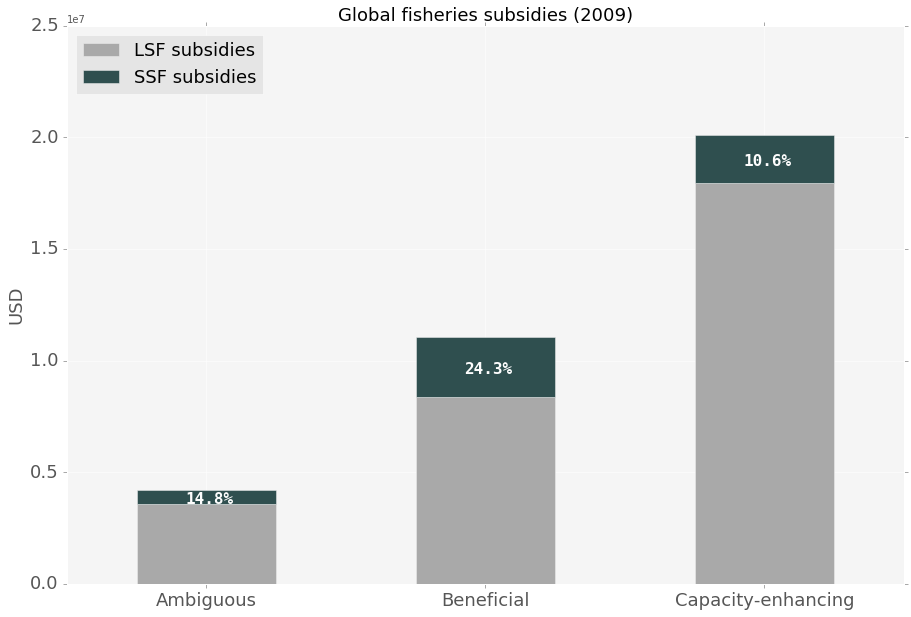

In [67]:

data = Subsidies_per_Category[['LSF subsidies','SSF subsidies']]
data_dict = data.to_dict()


# these percentages are the SSF percent out of the total subsidie calculated in Subsidies_per_Category['SSF percent']
SSFpercent = (
    {'label': 'Ambiguous', 'percentage': 14.8}, 
    {'label': 'Beneficial', 'percentage': 24.3},
    {'label': 'Capacity-enhancing', 'percentage': 10.6}
)

# add totals to SFFpercent
for key, val in data_dict.items():
    for k, v in data_dict[key].items():
        for i in SSFpercent:
            if i['label'] == k:
                if 'total' in i.keys():
                    i['total'] += v
                else:
                    i['total'] = v

# print("data_dict {}".format(data_dict))


# create subplot
ax = data.plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"])
ax.set_title("Global fisheries subsidies (2009)", fontsize=18)
ax.set_ylabel("USD",fontsize=18)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(['Ambiguous','Beneficial', 'Capacity-enhancing'],rotation=360, fontsize=18)
ax.set_axis_bgcolor('0.96')


# get an ordered list of percentages
percentages = []
for item in SSFpercent:
    for k, v in item.items():
        if k == 'percentage':
            percentages.append(v)

# prepare rects
N = len(SSFpercent)
indexes = np.arange(N)
width = 0.02
rects = ax.bar(indexes, percentages, width)

# iterate rects and map index with SSF percentage
for index, rect in enumerate(rects):
    SSFpercent[index]['rect_x'] = rect.get_x() 


# now we have a single object holding 
# all the values we need to label the chart 
for bar in SSFpercent:
    #  get percenatage label as a string
    percentage = bar['percentage']
    #  get value of to of bar
    height = bar['total']
    label_position = height - ((height / 100 * percentage) / 2)
    #  position text lables
    ax.text(
        bar['rect_x'] + width/2,
        label_position  - 12.4**5, str(percentage) + '%',
        ha="center",
        family="monospace",
        fontsize=16,
        fontweight="bold",
        color="white"
    )


plt.savefig('Subsidies_Category.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Category.pdf', dpi=400, bbox_inches='tight')
plt.legend(loc=2,fontsize=18)
plt.show()

In [68]:
SSF_subsidies_estimates_assessed.columns.values

array(['RegionName', 'Subregion', 'Countries', 'CLon', 'CLat', 'SIDS',
       'TotPop', 'HDI', 'Develop', 'GDP', 'Category', 'SubType', 'Type',
       'EEZ', 'total_subsidies', 'SSF_catch_percent',
       'SSF_subregion_catch', 'subsidies_subregion_all', 'Factor',
       'SSF_subsidies_estimates', 'SSF_subsidies_estimates_big',
       'SSF_estimates_corrected', 'SSFsubsidies_assessed_percent',
       'weighted_by_sectorsize', 'Data_group', 'SSF_USD_1000',
       'SSF_subsidies_percent', 'SSF_subsidies_percent_all',
       'SSF subsidies', 'LSF subsidies'], dtype=object)

In [69]:
Subsidies_per_subtype = SSF_subsidies_estimates_assessed.groupby(['SubType']).sum()
Subsidies_per_subtype = Subsidies_per_subtype.sort_values(by=['total_subsidies'],ascending=False)

Subsidies_per_subtype['SSF percent'] = Subsidies_per_subtype['SSF subsidies']/Subsidies_per_subtype['total_subsidies']*100
Subsidies_per_subtype_milions = Subsidies_per_subtype.loc[:,['LSF subsidies','SSF subsidies']]
Subsidies_per_subtype_milions['LSF subsidies'] = Subsidies_per_subtype_milions['LSF subsidies']/1000000
Subsidies_per_subtype_milions['SSF subsidies'] = Subsidies_per_subtype_milions['SSF subsidies']/1000000

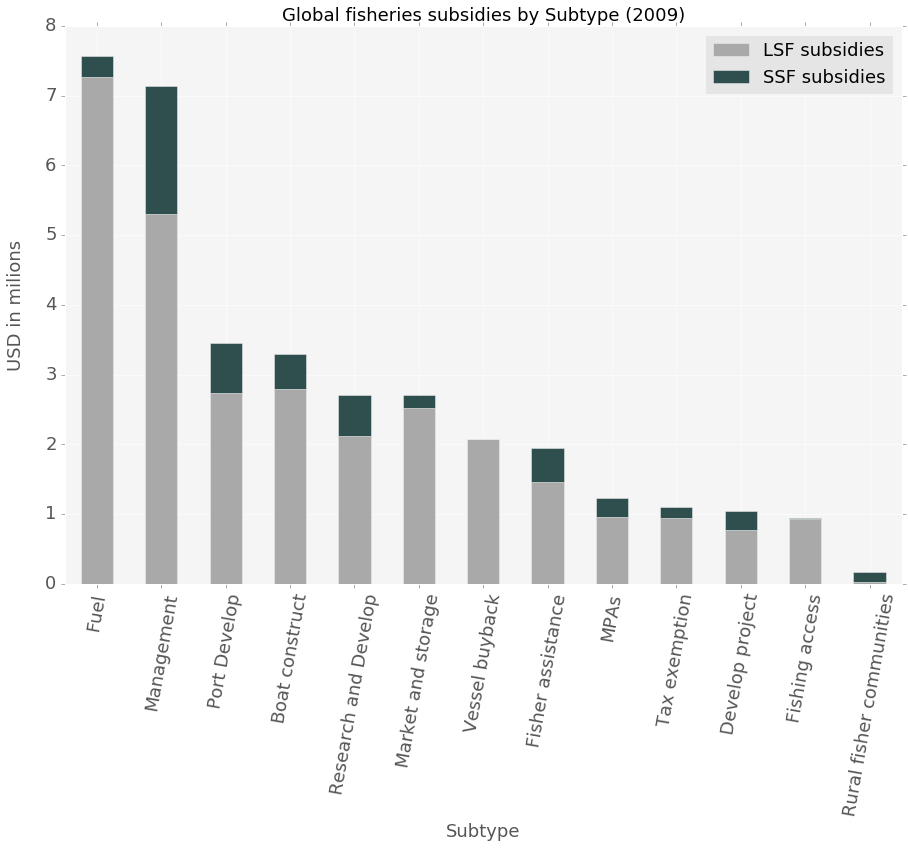

In [108]:
ax = Subsidies_per_subtype_milions[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"] )
ax.set_title("Global fisheries subsidies by Subtype (2009)", fontsize=18)
ax.set_ylabel("USD in milions",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_xlabel("Subtype",fontsize=18)
ax.set_xticklabels(['Fuel', 'Management','Port Develop','Boat construct','Research and Develop','Market and storage','Vessel buyback','Fisher assistance','MPAs','Tax exemption','Develop project','Fishing access','Rural fisher communities'],rotation=80, fontsize=18)
ax.set_axis_bgcolor('0.96')
plt.legend(loc='best',fontsize=18)
plt.savefig('Subsidies_Subtype.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Subtype.pdf', dpi=400, bbox_inches='tight')

plt.show()

In [98]:
Subsidies_per_subtype['LSF subsidies']

SubType
Fuel subsidies               7264771.369556
Fisheries mangt.             5303549.774708
Fishing port develop.        2737832.820821
Boat constsruct. & renov.    2796036.928422
Fishery R&D                  2120237.204720
Markt. & storage infrast.    2517786.849585
Vessel buyback               2076165.065567
Fisher assistance            1462834.087354
MPAs                          958405.862203
Tax exemption                 948174.372565
Fisheries dev. projects       776786.168990
Fishing access                934505.064408
Rural fisher communities       25947.312736
Name: LSF subsidies, dtype: float64

In [111]:
SSF_subsidies_estimates_assessed.columns.values

array(['RegionName', 'Subregion', 'Countries', 'CLon', 'CLat', 'SIDS',
       'TotPop', 'HDI', 'Develop', 'GDP', 'Category', 'SubType', 'Type',
       'EEZ', 'total_subsidies', 'SSF_catch_percent',
       'SSF_subregion_catch', 'subsidies_subregion_all', 'Factor',
       'SSF_subsidies_estimates', 'SSF_subsidies_estimates_big',
       'SSF_estimates_corrected', 'SSFsubsidies_assessed_percent',
       'weighted_by_sectorsize', 'Data_group', 'SSF_USD_1000',
       'SSF_subsidies_percent', 'SSF_subsidies_percent_all',
       'SSF subsidies', 'LSF subsidies'], dtype=object)

In [126]:
Subsidies_per_region = SSF_subsidies_estimates_assessed.groupby(['RegionName']).sum()
Subsidies_per_region['LSF subsidies'] = Subsidies_per_region['LSF subsidies']/1000000
Subsidies_per_region['SSF subsidies'] = Subsidies_per_region['SSF subsidies']/1000000
Subsidies_per_region = Subsidies_per_region.sort_values(by=['total_subsidies'],ascending=False)
Subsidies_per_region['SSF percent'] = (Subsidies_per_region['SSF subsidies']/(Subsidies_per_region['total_subsidies']/1000000)) *100
Subsidies_per_region['SSF percent'] 

RegionName
Asia                                     18.589692
Europe                                    7.033195
North America                            18.768241
Oceania                                   4.243141
South, Central America and Carribbean    30.890012
Africa                                   32.260159
Name: SSF percent, dtype: float64

KeyError: 'total'

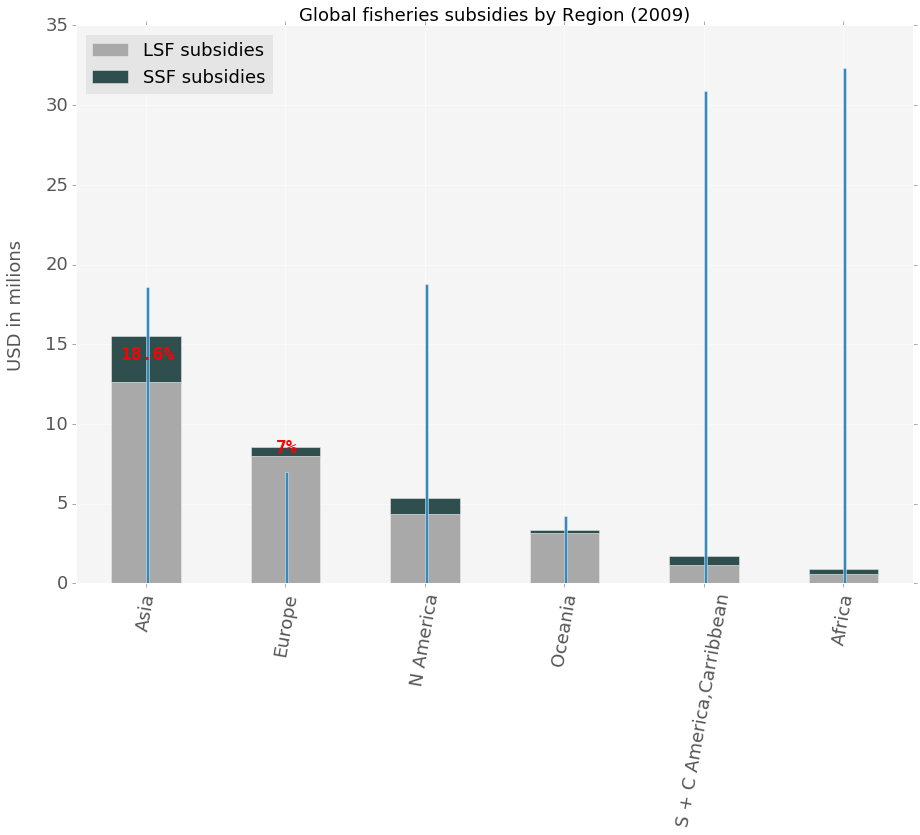

In [136]:

data = Subsidies_per_region[['LSF subsidies','SSF subsidies']]
data_dict = data.to_dict()


# these percentages are the SSF percent out of the total subsidie calculated in Subsidies_per_region['SSF percent']
SSFpercent = (
    {'label': 'Asia', 'percentage': 18.6}, 
    {'label': 'Europe', 'percentage': 7},
    {'label': 'N America', 'percentage': 18.8},
    {'label': 'Oceania', 'percentage': 4.2},
    {'label': 'S C America Carribbean', 'percentage': 30.9},
    {'label': 'Africa', 'percentage': 32.3}
)

# add totals to SFFpercent
for key, val in data_dict.items():
    for k, v in data_dict[key].items():
        for i in SSFpercent:
            if i['label'] == k:
                if 'total' in i.keys():
                    i['total'] += v
                else:
                    i['total'] = v

# make plot, also called subplot
ax = data[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"] )
ax.set_title("Global fisheries subsidies by Region (2009)", fontsize=18)
ax.set_ylabel("USD in milions",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(['Asia', 'Europe','N America','Oceania','S + C America,Carribbean', 'Africa'],rotation=80, fontsize=18)
ax.set_axis_bgcolor('0.96')
plt.legend(loc='best',fontsize=18)


# get an ordered list of percentages
percentages = []
for item in SSFpercent:
    for k, v in item.items():
        if k == 'percentage':
            percentages.append(v)
            
# prepare rects (rectangles)
N = len(SSFpercent)
indexes = np.arange(N)
width = 0.02
rects = ax.bar(indexes, percentages, width)

# iterate rects and map index with SSF percentage
for index, rect in enumerate(rects):
    SSFpercent[index]['rect_x'] = rect.get_x() 

    # now we have a single object holding 
# all the values we need to label the chart 
for bar in SSFpercent:
    #  get percentage label as a string
    percentage = bar['percentage']
    #  get value of to of bar
    height = bar['total']
    label_position = height - ((height / 100 * percentage) / 2)
    #  position text lables
    ax.text(
        bar['rect_x'] + width/2,
        label_position  - 0.5**5, str(percentage) + '%',
        ha="center",
        family="monospace",
        fontsize=18,
        fontweight="bold",
        color="red"
    )

    

plt.savefig('Subsidies_Region.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Region.pdf', dpi=400, bbox_inches='tight')

plt.show()